In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import h5py
import json
import os

from analysis import plot, utils, process # imoporting analysis module enables import from model folder

%matplotlib inline

TRIAL_NAME = "long_nassy_20"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

In [2]:
stimulus_type, config = utils.stimulus_type_from_trial_name(TRIAL_NAME)
isbaseline = stimulus_type == 'baseline' or stimulus_type == 'const'
isstandard = isbaseline or stimulus_type == 'short' or stimulus_type == 'long'

pop_color = plot.pop_color
pop_names = plot.pop_names

In [3]:
result_config_file = os.path.join('..', 'Analysis', TRIAL_PATH, 
                                  'config_no_STP.json' if 'no_STP' in TRIAL_NAME else config)
if not os.path.isfile(result_config_file):
    result_config_file = os.path.join(os.path.split(result_config_file)[0], utils.STIMULUS_CONFIG['else'])

config_hp = utils.ConfigHelper(result_config_file)

INPUT_PATH, _ = os.path.split(config_hp.get_attr('inputs', 'baseline_spikes', 'input_file'))
STIM_FILE = config_hp.get_attr('inputs', 'thalamus_spikes', 'input_file')

stim_file = 'standard_stimulus' if isstandard else os.path.splitext(os.path.split(STIM_FILE)[1])[0]
with open(os.path.join(INPUT_PATH, stim_file + '.json')) as f:
    stim_setting = json.load(f)
stim_params = stim_setting['short' if isbaseline else (stimulus_type if isstandard else 'stim_params')]

t_start = stim_params['t_start']
on_time, off_time = stim_params['on_time'], stim_params['off_time']

### Load data

In [4]:
elec_id = 0
lfps = utils.load_ecp_to_xarray(os.path.join(TRIAL_PATH, 'ecp.h5'))
n_channel = lfps.channel_id.size
lfp = lfps.sel(channel_id=elec_id)
# display(lfps)

In [5]:
with h5py.File(os.path.join(TRIAL_PATH, 'spike_rate.h5'), 'r') as f:
    pop_rspk = xr.DataArray(
        np.stack([g['data'] for g in f['populations'].values()], axis=0),
        coords = dict(
            population = list(f['populations'].keys()),
            time = np.arange(*f['time'])
        ),
        attrs = dict(
            fs = 1000 / f['time'][2]
        )
    ).to_dataset(name='spike_number', promote_attrs=True)
    pop_rspk.update(dict(
        population_number = xr.DataArray(
            [g.attrs['number'] for g in f['populations'].values()],
            coords = dict(
                population = pop_rspk.coords['population']
            )
        )
    ))
# display(pop_rspk)

In [6]:
spike_groups = [['CP', 'CS'], ['FSI'], ['LTS']]
group_label = [' + '.join(spk_grp) for spk_grp in spike_groups]
group_color = [pop_color[spk_grp[0]] for spk_grp in spike_groups]

group_rspk = xr.concat([pop_rspk.sel(population=grp).sum(dim='population', keep_attrs=True)
                        for grp in spike_groups], dim=pd.Index(group_label, name='population'))
spike_rate = group_rspk.fs / group_rspk.population_number * group_rspk.spike_number
spike_rate_std = spike_rate.std(dim='time')
idx = spike_rate_std.values > 0
spike_rate_norm = spike_rate - spike_rate.mean(dim='time')
spike_rate_norm[idx] /= spike_rate_std[idx]
group_rspk.update(dict(
    spike_rate = spike_rate,
    spike_rate_norm = spike_rate_norm,
    spike_rate_std = spike_rate_std
))
# display(group_rspk)

<xarray.Dataset>
Dimensions:            (time: 18400, population: 3)
Coordinates:
  * time               (time) float64 0.0 2.5 5.0 ... 4.599e+04 4.6e+04 4.6e+04
  * population         (population) object 'CP + CS' 'FSI' 'LTS'
Data variables:
    spike_number       (population, time) int64 0 0 13 24 17 33 ... 6 9 7 13 6 6
    population_number  (population) int32 8000 1200 800
    spike_rate         (population, time) float64 0.0 0.0 0.65 ... 6.5 3.0 3.0
    spike_rate_norm    (population, time) float64 -4.622 -4.622 ... -1.294
    spike_rate_std     (population) float64 0.4031 3.483 3.716
Attributes:
    fs:       400.0

### Calculate PSD

In [7]:
tseg = 0.5  # time segment length for PSD

if isbaseline:
    on_time, off_time = on_time + off_time, 0.0
else:
#     # if any correction needed
#     t_start = 1.25  # sec. Time to start burst input
#     on_time = 0.75  # sec. Burst input duration
#     off_time = 0.75  # sec. Silence duration
    windows = process.get_stim_windows(on_time, off_time, t_start,
                                       lfps.time[-1] / 1000)

In [8]:
f, pxx, lfp_stim_cycle = process.get_psd_on_stimulus(
    lfps, lfps.fs, on_time, off_time, t_start, t=lfps.time, tseg=tseg)
psd_lfp = xr.DataArray(pxx, coords={'channel': lfps.channel_id.values, 'frequency': f})

psd_rspk = []
valid_grp = []
for grp in group_label:
    rspk = group_rspk.sel(population=grp)
    if rspk.spike_rate_std > 0:
        f, pxx, rspk_stim_cycle = process.get_psd_on_stimulus(
            rspk.spike_rate_norm, rspk.fs, on_time, off_time, t_start, t=rspk.time, tseg=tseg)
        psd_rspk.append(pxx)
        valid_grp.append(grp)
psd_rspk = xr.DataArray(np.array(psd_rspk), coords={'population': valid_grp, 'frequency': f})

### Plot traces

#### LFP

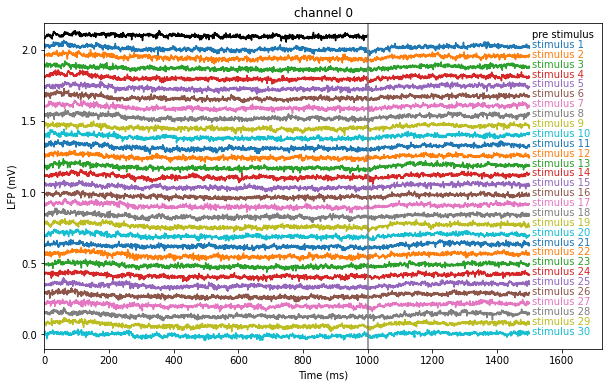

In [9]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.plot_stimulus_cycles(lfp.time, lfp.values, lfp_stim_cycle, dv_n_sigma=5., var_label='LFP (mV)', ax=ax)
plt.title('channel %d' % lfp.channel_id)
plt.show()

#### Spike time histogram

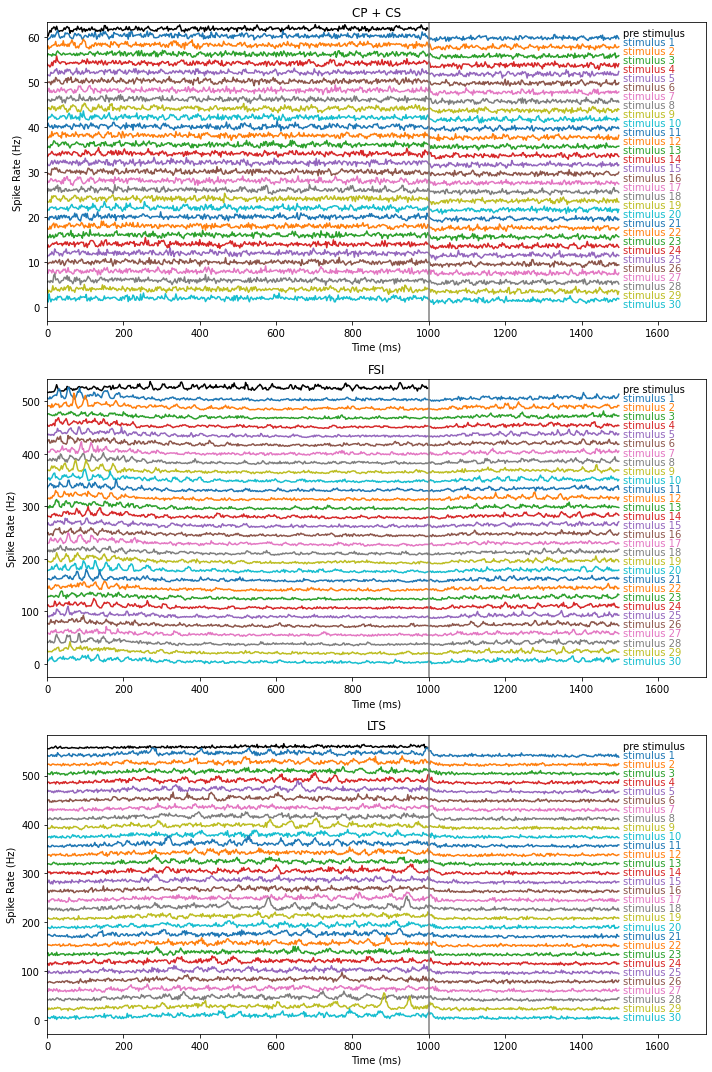

In [10]:
_, axs = plt.subplots(len(spike_groups), 1, figsize=(10, 5 * len(spike_groups)))
for i, ax in enumerate(axs):
    rspk = group_rspk.spike_rate.isel(population=i)
    plot.plot_stimulus_cycles(rspk.time, rspk.values, rspk_stim_cycle, dv_n_sigma=5., var_label='Spike Rate (Hz)', ax=ax)
    axs[i].set_title(rspk.population.item())
plt.tight_layout()
plt.show()

### PSD of LFP

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 4 - 600 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -4.7563, 1.1337                                          
                                                                                                  
                                       10 peaks were found:                                       
          

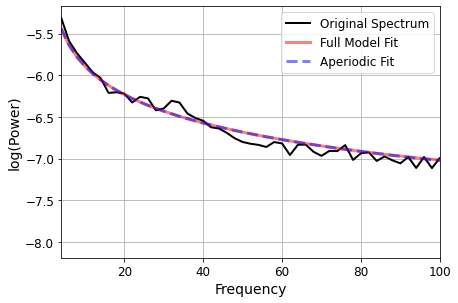

In [11]:
fooof_params = dict(aperiodic_mode='fixed', freq_range=600., peak_width_limits=100.)
plt_range = 100.
plt_log = False
figsize = (6, 4)

if n_channel <= 1:
    results = plot.fit_fooof(psd_lfp.frequency.values, psd_lfp.sel(channel=elec_id), **fooof_params,
                             report=True, plot=True, plt_log=plt_log, plt_range=plt_range, figsize=figsize)
else:
    results, _, _ = plot.plot_channel_psd(psd_lfp, channel_id=elec_id, **fooof_params,
                                          plt_log=plt_log, plt_range=plt_range, figsize=figsize)
results, fm = results

save_fooof = False
if save_fooof:
    SAVE_PATH = os.path.join(TRIAL_PATH, 'FOOOF_results')
    fm.save(SAVE_PATH, save_results=True, save_settings=True, save_data=True)

    # Save out a report of the current model fit & results
    REPORT_PATH = os.path.join(TRIAL_PATH, 'FOOOF_report')
    fm.save_report(REPORT_PATH, plt_log=plt_log)

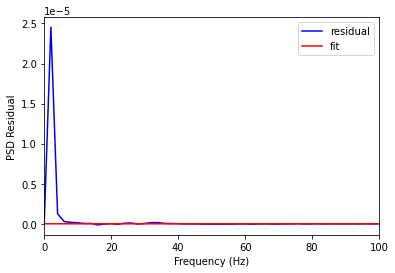

In [12]:
_, ax = plt.subplots(1, 1, figsize=figsize)
_ = plot.psd_residual(psd_lfp.frequency.values, psd_lfp.sel(channel=elec_id).values,
                      results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
yl = plt.gca().get_ylim()
plt.gca().set_ylim(bottom=max(yl[0], -yl[1]))
plt.show()

#### Scalogram

In [13]:
tres = 0.004 # sec. time resolution (0.005 at most for 200 Hz sampling rate)
use_cwt = True
axis = lfps.dims.index('time')

if use_cwt:
    # Use wavelet
    lfp_sxx = plot.cwt_spectrogram_xarray(lfps, lfps.fs, axis=axis, downsample_fs=1 / tres,
                                          channel_coords={'channel_id': lfps.channel_id}, freq_range=(1 / tseg, np.inf))
else:
    # Use spectrogram
    lfp_sxx = plot.spectrogram_xarray(lfps, lfps.fs, tseg, axis=axis, tres=np.inf,
                                      channel_coords={'channel_id': lfps.channel_id})

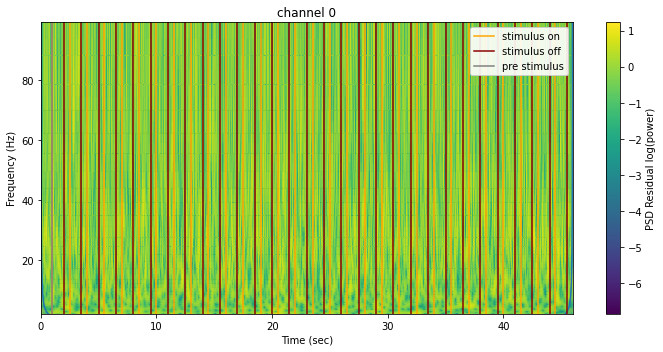

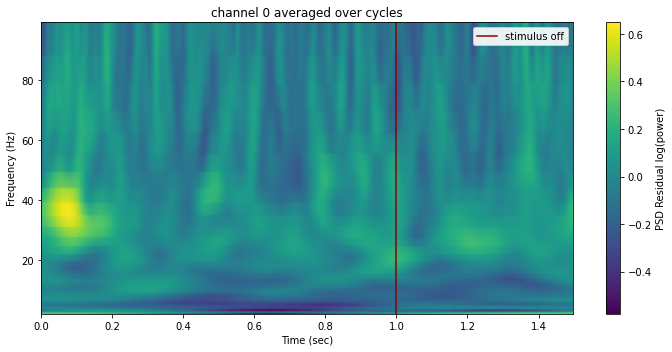

In [14]:
remove_aperiodic = fooof_params
log_power = True
clr_freq_range = None

_, axs = plt.subplots(n_channel, 1, figsize=(10, 5 * n_channel), squeeze=False)
for i, ax in enumerate(axs.ravel()):
    sxx = lfp_sxx.isel(channel_id=i)
    if remove_aperiodic is None:
        fooof_results = None
    else:
        sxx_tot = sxx.PSD.mean(dim='time')
        fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
    _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results, log_power=log_power, plt_range=plt_range,
                              clr_freq_range=clr_freq_range, ax=ax)
    ax.set_title(f'channel {sxx.channel_id.item():d}')
    if not isbaseline:
        for j, win in enumerate(windows):
            labels = [None, None] if j else ['stimulus on', 'stimulus off']
            ax.axvline(win[0], color='orange', label=labels[0])
            ax.axvline(win[1], color='darkred', label=labels[1])
        ax.axvline(t_start, color='gray', label='pre stimulus')
    ax.legend(loc='upper right', framealpha=0.9)
plt.tight_layout()

if not isbaseline:
    cyc_wins = process.get_stim_windows(on_time, off_time, t_start,
                                       lfps.time[-1] / 1000, win_extend=off_time)
    _, _, lfp_sxx_avg = process.get_windowed_data(lfp_sxx.PSD, cyc_wins, {0: np.arange(cyc_wins.shape[0])})
    lfp_sxx_avg = lfp_sxx_avg[0].mean_.sel(unique_cycle=0).to_dataset(name='PSD')

    _, axs = plt.subplots(n_channel, 1, figsize=(10, 5 * n_channel), squeeze=False)
    for i, ax in enumerate(axs.ravel()):
        sxx = lfp_sxx_avg.isel(channel_id=i)
        if remove_aperiodic is None:
            fooof_results = None
        else:
            sxx_tot = sxx.PSD.mean(dim='time')
            fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
        _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results, log_power=log_power, plt_range=plt_range,
                                clr_freq_range=clr_freq_range, ax=ax)
        ax.set_title(f'channel {sxx.channel_id.item():d}' + ' averaged over cycles')
        ax.axvline(on_time, color='darkred', label='stimulus off')
        ax.legend(loc='upper right', framealpha=0.9)
    plt.tight_layout()
plt.show()

### PSD of spike time histogram

In [15]:
axis = group_rspk.spike_rate_norm.dims.index('time')

if use_cwt:
    # Use wavelet
    rspk_sxx = plot.cwt_spectrogram_xarray(
        group_rspk.spike_rate_norm.sel(population=valid_grp), group_rspk.fs, axis = axis, downsample_fs=1 / tres,
        channel_coords={'population': valid_grp}, freq_range=(1 / tseg, np.inf))
else:
    # Use spectrogram
    rspk_sxx = plot.spectrogram_xarray(
        group_rspk.spike_rate_norm.sel(population=valid_grp), group_rspk.fs, tseg,
        axis=axis, tres=np.inf, channel_coords={'population': valid_grp})

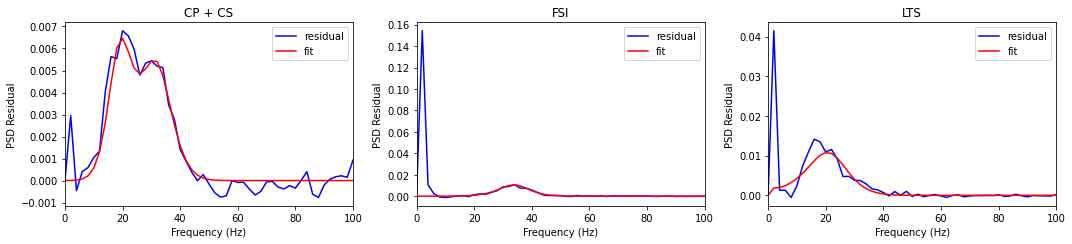

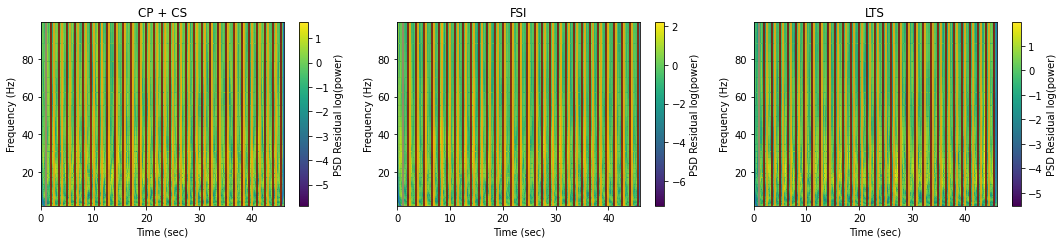

In [16]:
remove_aperiodic = fooof_params
log_power = True
clr_freq_range = None
down_fs = 40.  # Hz. downsample frequency

ngrps = psd_rspk.population.size
fig1, axs1 = plt.subplots(1, ngrps, figsize=(5 * ngrps, 3.5))
fig2, axs2 = plt.subplots(1, ngrps, figsize=(5 * ngrps, 3.5))

for i, grp in enumerate(valid_grp):
    ax = axs1[i]
    psd = psd_rspk.sel(population=grp)
    spk_results, _ = plot.fit_fooof(f, psd, **fooof_params, report=False, plot=False)
    _ = plot.psd_residual(psd.frequency.values, psd.values,
                          spk_results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
    ax.set_title(grp)
    yl = ax.get_ylim()
    ax.set_ylim(bottom=max(yl[0], -yl[1]))

    ax = axs2[i]
    sxx = rspk_sxx.sel(population=grp)
    if remove_aperiodic is None:
        fooof_results = None
    else:
        sxx_tot = sxx.PSD.mean(dim='time')
        fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
    _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results, log_power=log_power, plt_range=plt_range,
                              clr_freq_range=clr_freq_range, ax=ax)
    ax.set_title(grp)
    if not isbaseline:
        for j, win in enumerate(windows):
            labels = [None, None] if j else ['stimulus on', 'stimulus off']
            ax.axvline(win[0], color='orange', label=labels[0])
            ax.axvline(win[1], color='darkred', label=labels[1])
        ax.axvline(t_start, color='gray', label='pre stimulus')
fig1.tight_layout()
fig2.tight_layout()
plt.show()

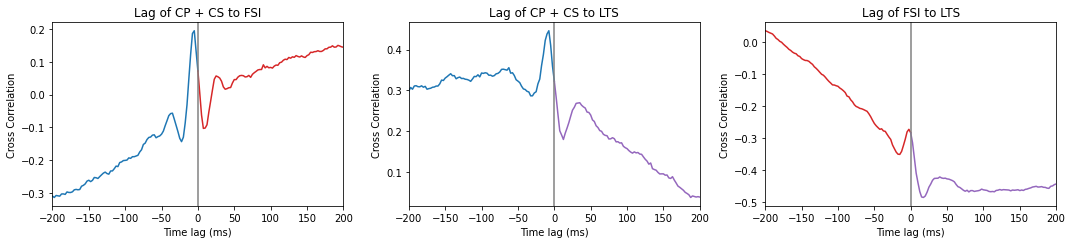

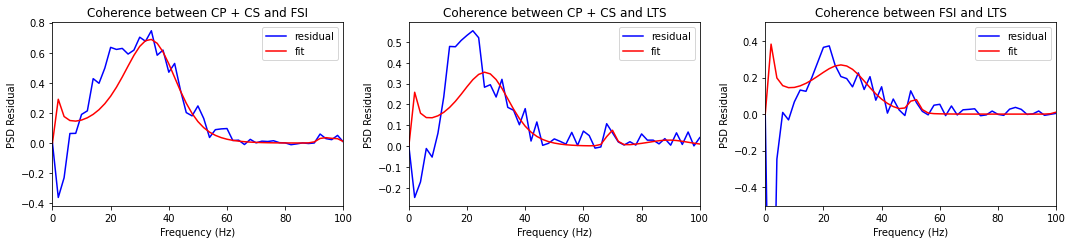

In [17]:
max_lag = 200. # ms
xcorr_color = True
grp_pairs = [[0, 1], [0, 2], [1, 2]]

dt = 1000 / group_rspk.fs
npairs = len(grp_pairs)

fig3, axs3 = plt.subplots(1, npairs, figsize=(5 * npairs, 3.5))
fig4, axs4 = plt.subplots(1, npairs, figsize=(5 * npairs, 3.5))

for i, grp_pair in enumerate(grp_pairs):
    rspk_pair = group_rspk.sel(population=[group_label[grp_pair[0]], group_label[grp_pair[1]]])
    if not rspk_pair.spike_rate_std.all():
        continue

    # cross-correlation
    ax = axs3[i]
    rspk_pair_win = rspk_pair.spike_rate_norm.sel(time=slice(t_start, None))
    if xcorr_color:
        idx0 = min(int(max_lag / dt), rspk_pair_win.time.size - 1)
        xcorr, xcorr_lags = plot.xcorr_coeff(*rspk_pair_win.values, dt=dt, max_lag=max_lag, plot=False)
        ax.plot(xcorr_lags[:idx0 + 1], xcorr[:idx0 + 1], color=group_color[grp_pair[0]])
        ax.plot(xcorr_lags[idx0:], xcorr[idx0:], color=group_color[grp_pair[1]])
        ax.axvline(0., color='gray')
        ax.set_xlim(xcorr_lags[[0, -1]])
        ax.set_ylabel('Cross Correlation')
    else:
        xcorr, xcorr_lags = plot.xcorr_coeff(*rspk_pair_win.values, dt=dt, max_lag=max_lag, ax=ax)
    ax.set_xlabel('Time lag (ms)')
    ax.set_title('Lag of %s to %s' % tuple(rspk_pair.population.values))

    # coherence
    ax = axs4[i]
    f, cxy = process.get_coh_on_stimulus(*rspk_pair.spike_rate_norm, rspk_pair.fs, on_time, off_time,
                                      t_start, t=rspk_pair.time, tseg=tseg)
    idx = cxy > 0
    if not np.any(idx):
        continue
    # calculate residual
    fooof_results, _ = plot.fit_fooof(f[idx], cxy[idx], **fooof_params, report=False, plot=False)
    _ = plot.psd_residual(f, cxy, fooof_results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=ax)
    yl = ax.get_ylim()
    ax.set_ylim(bottom=max(yl[0], -yl[1]))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_title('Coherence between %s and %s' % tuple(rspk_pair.population.values))
fig3.tight_layout()
fig4.tight_layout()
plt.show()